In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.models import resnet18
from torchvision import transforms
from tqdm import tqdm
from torch import nn
from torch.utils.data import Dataset,TensorDataset,DataLoader,random_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from d2l import torch as d2l
import random
import os
import torch.nn.functional as F
from torch.autograd import grad
import torch.nn.init as init
d2l.use_svg_display()

import math

['2C_battery-1', '2C_battery-2', '2C_battery-3', '2C_battery-4', '2C_battery-5', '2C_battery-6', '2C_battery-7', '2C_battery-8']


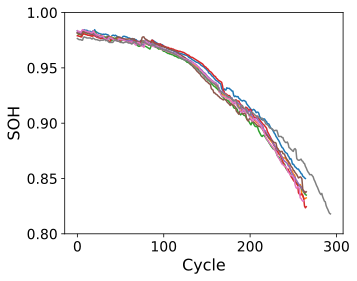

In [2]:
Batch_list=['Batch-1','Batch-2','Batch-3','Batch-4','Batch-5','Batch-6']
def choose_batch(Batch_name):
    Battery_list=[]
    dir='../source_data/XJTU_data/'+Batch_name
    for name in os.listdir(dir):
        Battery_list.append(name.strip('.mat'))
    source_data_path='../source_data/XJTU_data/'+Batch_name+'/'
    target_data_path='../data/XJTU_data/'+Batch_name+'/'+'all/'
    return Battery_list,source_data_path,target_data_path
Battery_list,source_data_path,target_data_path=choose_batch(Batch_list[0])
print(Battery_list)
def smooth_data(sequence, window_size):
    """数据平滑"""
    if window_size < 1:
        raise ValueError("窗口大小必须大于等于1")
    # 初始化平滑后的数据列表
    smoothed_sequence = []
    # 计算窗口内的平均值
    for i in range(len(sequence)):
        # 计算窗口的起始和结束索引
        start_index = max(0, i - window_size + 1)
        end_index = i + 1
        # 计算窗口内的数据平均值
        window_average = sum(sequence[start_index:end_index]) / (end_index - start_index)
        # 将平均值添加到平滑后的数据列表中
        smoothed_sequence.append(window_average)
    return smoothed_sequence
def add_row_index_to_array(arr):
    """
    在输入数组的每一行的第一个元素加上行号，并扩展数组维度。
    
    参数:
    arr (np.ndarray): 形状为 (n, 6) 的输入数组。
    
    返回:
    np.ndarray: 形状为 (n, 7) 的数组。
    """
    # 检查输入数组形状是否为 (n, 6)
    if arr.shape[1] != 10:
        raise ValueError("输入数组必须是形状为 (n, 10) 的数组。")

    # 创建一个新数组，其形状为 (n, 7)，初始化为输入数组
    new_arr = np.zeros((arr.shape[0], 11))
    new_arr[:, 1:] = arr  # 将输入数组的数据复制到新数组的后面六个列
    # 在新数组的每一行的第一个元素加上行号
    new_arr[:, 0] = np.arange(arr.shape[0])
    return new_arr
def make_sequences(text, window_size):
    """用容量作为文本序列text,window是窗口的大小"""
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+window_size]

        x.append(sequence)
        y.append(target)
    return np.array(x), np.array(y)
def drop_outlier(array,count,bins):
    """离群值提取--用3sigma方法"""
    index = []
    range_n = np.arange(1,count,bins)
    for i in range_n[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)
def clean_data(array_figs,array_labels):
    index_keep=drop_outlier(array_labels,len(array_labels),35)
    array_figs,array_labels=array_figs[index_keep],array_labels[index_keep]
    array_figs,array_labels=array_figs[drop_outlier(array_labels,len(array_labels),10)],array_labels[drop_outlier(array_labels,len(array_labels),10)]
    return array_figs,array_labels
data_root=target_data_path
plt.figure(figsize=(5, 4))
for name in Battery_list:
    path=data_root+name+'.npz'
    arrays=np.load(path)
    features,SOHs=clean_data(arrays['array1'],arrays['array2'])
    plt.plot(SOHs/2.0)
    # """抛弃异常值处理"""
    # index_keep=drop_outlier(SOHs,len(SOHs),35)
    # plt.plot(SOHs[index_keep][drop_outlier(SOHs[index_keep],len(SOHs[index_keep]),10)])
    # plt.plot(process_sequence(SOHs,1))
    plt.yticks([0.8,0.85,0.9,0.95,1],fontsize=14)
    plt.xticks([0,100,200,300],fontsize=14)
    plt.xlabel('Cycle', fontsize=16)
    plt.ylabel('SOH',fontsize=16)
    # print(features[1][0])
# plt.show()

In [3]:
def setup_seed(seed):
    """set random seed"""
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

def evaluation(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return rmse
def get_data():
    """获取训练集，测试集，验证集"""
    train_list = Battery_list
    train_data=[]
    for b_n in train_list:
        path=data_root+b_n+'.npz'
        arrays = np.load(path)
        a,b=clean_data(arrays['array1'],arrays['array2'])
        a=add_row_index_to_array(a)
        train_data.append([a,b])
    train_features=np.concatenate((train_data[0][0],train_data[1][0],train_data[2][0],train_data[3][0],train_data[4][0]),axis=0)
    train_labls=np.concatenate((train_data[0][1],train_data[1][1],train_data[2][1],train_data[3][1],train_data[4][1]),axis=0)
    train_valid_features=torch.from_numpy(train_features).float()
    train_valid_labels=torch.from_numpy(train_labls).float()
    dataset=TensorDataset(train_valid_features,train_valid_labels)
    # 确定训练集和验证集的大小
    train_size = int(0.2 * len(dataset))  # 80%的训练集
    val_size = len(dataset) - train_size   # 剩余的20%作为验证集
    # 随机分割数据集
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    # 创建DataLoader
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_5_data,test_6_data,test_7_data=[np.concatenate((train_data[5][0],train_data[0][0],train_data[1][0],train_data[2][0]),axis=0),np.concatenate((train_data[5][1],train_data[0][1],train_data[1][1],train_data[2][1]),axis=0)],[train_data[6][0],train_data[6][1]],[train_data[7][0],train_data[7][1]]
    return train_loader, val_loader, test_5_data,test_6_data,test_7_data

a,b,c,d,e=get_data()
print(d,e)
for x,y in b:
    print(x.shape)

[array([[0.00000000e+00, 8.10116599e-01, 2.05529220e-01, ...,
        7.50713571e-01, 1.00000000e+00, 5.46999916e-03],
       [1.00000000e+00, 8.10116599e-01, 2.05529220e-01, ...,
        7.50713571e-01, 1.00000000e+00, 5.46999916e-03],
       [2.00000000e+00, 8.10116599e-01, 2.05529220e-01, ...,
        7.50713571e-01, 1.00000000e+00, 5.46999916e-03],
       ...,
       [2.60000000e+02, 4.56911290e-01, 8.30281021e-01, ...,
        7.14768346e-01, 1.10282954e-01, 5.22973996e-01],
       [2.61000000e+02, 4.64166178e-01, 7.90670802e-01, ...,
        7.24159078e-01, 1.04209800e-01, 5.26676765e-01],
       [2.62000000e+02, 4.68563913e-01, 7.76807393e-01, ...,
        7.15860345e-01, 9.82746722e-02, 5.29832534e-01]]), array([1.967, 1.966, 1.966, 1.965, 1.964, 1.967, 1.969, 1.968, 1.968,
       1.967, 1.966, 1.966, 1.965, 1.965, 1.965, 1.964, 1.963, 1.963,
       1.964, 1.966, 1.963, 1.962, 1.96 , 1.959, 1.96 , 1.958, 1.957,
       1.957, 1.957, 1.958, 1.956, 1.954, 1.953, 1.952, 1.951, 1.95

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim=11, output_dim=12, num_heads=4, head_dim=24, dropout=0):
        """用多头注意力进行解码"""
        """
        多头注意力模块。
        :param input_dim: 输入特征维度
        :param output_dim: 输出特征维度
        :param num_heads: 注意力头的数量
        :param head_dim: 每个注意力头的维度
        :param dropout: Dropout 概率
        """
        super(MultiHeadAttention, self).__init__()
        self.input_dim = input_dim-1
        self.output_dim = output_dim-1
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.dropout = dropout
        # 线性变换层，将输入映射到 Q, K, V
        self.query = nn.Linear(input_dim-1, num_heads * head_dim)
        self.key = nn.Linear(input_dim-1, num_heads * head_dim)
        self.value = nn.Linear(input_dim-1, num_heads * head_dim)
        # 输出线性层
        self.fc_out = nn.Linear(num_heads * head_dim, output_dim-1)
        # Dropout 层
        self.dropout_layer = nn.Dropout(dropout)
    def forward(self, x):
        """
        前向传播。
        :param x: 输入张量，形状为 (batch_size, input_dim)
        :return: 输出张量，形状为 (batch_size, output_dim)
        """
        batch_size = x.size(0)
        x_t=x[:,0].unsqueeze(1)
        x=x[:,1:]
        # 线性变换，得到 Q, K, V
        Q = self.query(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        K = self.key(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)    # (batch_size, num_heads, seq_len, head_dim)
        V = self.value(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        # 计算注意力分数
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))  # (batch_size, num_heads, seq_len, seq_len)
        attention_weights = F.softmax(scores, dim=-1)  # (batch_size, num_heads, seq_len, seq_len)
        attention_weights = self.dropout_layer(attention_weights)
        # 计算加权和
        attention_output = torch.matmul(attention_weights, V)  # (batch_size, num_heads, seq_len, head_dim)
        # 拼接多头输出
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.head_dim)  # (batch_size, seq_len, num_heads * head_dim)
        # 通过线性层映射到输出维度
        output = self.fc_out(attention_output)  # (batch_size, seq_len, output_dim)
        output=torch.cat((x_t,output.squeeze(1)),dim=-1)
        return output  # (batch_size, output_dim)
"""--------------------------------------------------------多物理场混合专家模型-------------------------------------------------------"""
class MixtureOfExperts(nn.Module):
    def __init__(self, input_dim, num_experts, expert_hidden_dim):
        super(MixtureOfExperts, self).__init__()
        self.num_experts = num_experts
        # 专家网络
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, 2*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(2*expert_hidden_dim, 4*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(4*expert_hidden_dim, 8*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(8*expert_hidden_dim, 16*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(16*expert_hidden_dim, 32*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(32*expert_hidden_dim,64*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(64*expert_hidden_dim,32*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(32*expert_hidden_dim,16*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(16*expert_hidden_dim, 8*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(8*expert_hidden_dim, 4*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(4*expert_hidden_dim,expert_hidden_dim ),
            )
            for _ in range(num_experts)
        ])
        # 门控网络
        self.gating_network = nn.Linear(input_dim, num_experts)
        # 输出层
        self.output_layer = nn.Linear(expert_hidden_dim, 1)
    def initialize_weights(self):
        nn.init.xavier_uniform_(self.gating_network.weight)
        nn.init.xavier_uniform_(self.output_layer.weight)
    def forward(self, x):
        # 计算所有专家的输出
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)
        #shape(batch_size,num_expert,expert_hidden_dim)
        # 计算门控网络的输出并应用softmax得到权重
        gate_works=torch.exp(self.gating_network(x)/10)
        gating_outputs = F.softmax(gate_works, dim=1)
        # 将门控网络的输出（权重）与专家网络的输出相乘并求和
        combined_output = torch.sum(expert_outputs * gating_outputs.unsqueeze(-1), dim=1)
        # 通过输出层得到最终输出
        final_output = self.output_layer(combined_output)
        return final_output,expert_outputs      #返回总输出和每个专家输出
    
class PINN_MOE(nn.Module):
    def __init__(self,input_dim=11, output_dim=12, num_heads=4, head_dim=24, dropout=0,expert_input_dim=12, num_experts=3,expert_hidden_dim=2):
        super(PINN_MOE, self).__init__()
        self.Decoupling=MultiHeadAttention(input_dim, output_dim, num_heads, head_dim, dropout)
        self.multi_physics=MixtureOfExperts(expert_input_dim, num_experts,expert_hidden_dim)
        self.physics=nn.Sequential(
            nn.Linear(6, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )
        # self.electricity=nn.Sequential(nn.Linear(expert_hidden_dim, 2*expert_hidden_dim),nn.ReLU(),nn.Linear(2*expert_hidden_dim,expert_hidden_dim),nn.ReLU(),nn.Linear(expert_hidden_dim,2))
        # self.heat=nn.Sequential(nn.Linear(expert_hidden_dim, 2*expert_hidden_dim),nn.ReLU(),nn.Linear(2*expert_hidden_dim,expert_hidden_dim),nn.ReLU(),nn.Linear(expert_hidden_dim,2))
        # self.mechine=nn.Sequential(nn.Linear(expert_hidden_dim, 2*expert_hidden_dim),nn.ReLU(),nn.Linear(2*expert_hidden_dim,expert_hidden_dim),nn.ReLU(),nn.Linear(expert_hidden_dim,2))
        self.parameter_heat=nn.Parameter(torch.tensor(1, dtype=torch.float32))
        self.parameter_electricity1=nn.Parameter(torch.tensor(1, dtype=torch.float32))
        self.parameter_electricity2=nn.Parameter(torch.tensor(1, dtype=torch.float32))
    def  initialize_weights(self):
        nn.init.xavier_uniform_(self.Decoupling.parameters)
        nn.init.xavier_uniform_(self.multi_physics.parameters)
        # nn.init.xavier_uniform_(self.heat.parameters)
        # nn.init.xavier_uniform_(self.mechine.parameters)
        # nn.init.xavier_uniform_(self.electricity.parameters)
        nn.init.xavier_uniform_(self.physics.parameters)
        nn.init.xavier_uniform_(self.parameter_heat)
        nn.init.xavier_uniform_(self.parameter_electricity1)
        nn.init.xavier_uniform_(self.parameter_electricity2)
    def forward(self, tx):
        tx.requires_grad_(True)
        # 解耦输入
        t_x = self.Decoupling(tx)
        t=t_x[:,0:1]
        x=t_x[:,1:]
        # 预测物理量
        s_pred,experts = self.multi_physics(torch.cat((t,x),dim=1))
        # 计算 s_pred 对 t 和 x 的偏导数
        """综合损失"""
        s_t = grad(s_pred.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        s_x = grad(s_pred.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        """热效应损失"""
        T_Q=experts[:,0:1,:].squeeze(1)
        # print(T_Q.shape)
        T=T_Q[:,0:1]
        Q=T_Q[:,1:2]
        T_t=grad(T.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        T_x=grad(T.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        T_laplace=grad(T_t.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        loss_heat=torch.mean((T_t - (self.parameter_heat) * T_laplace - Q) ** 2, dim=1).unsqueeze(1)
        """电化学效应损失"""
        phi_c=experts[:,1:2,:].squeeze(1)
        phi=phi_c[:,0:1]
        c=phi_c[:,1:2]
        phi_t=grad(phi.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        phi_x=grad(phi.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        c_x=grad(c.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        c_t=grad(c.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        phi_laplace=grad(phi_x.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        c_laplace=grad(c_x.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        loss_electricity=torch.mean((c_t -self.parameter_electricity1 * c_laplace -self.parameter_electricity2) ** 2,dim=1).unsqueeze(1)+torch.mean(phi_laplace** 2,dim=1).unsqueeze(1)
        """机械应力损失"""
        sigma_f=experts[:,2:3,:].squeeze(1)
        sigma=sigma_f[:,0:1]
        f=sigma_f[:,1:2]
        sigma_x=grad(sigma.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        sigma_laplace=grad(sigma_x.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        loss_mechine=torch.mean((sigma_laplace + f) ** 2,dim=1).unsqueeze(1)
        # 打印 s_t 和 s_x，确保它们不为 None
        # 计算物理约束 F
        F_input = torch.cat([phi,c,T,Q,sigma,f], dim=1)
        soh = self.physics(F_input)
        # 计算残差 f
        loss_all = 1*loss_electricity+1*loss_heat+1*loss_mechine
        return soh, loss_all,[phi,c,T,Q,sigma,f]
        

In [5]:
def train(lr=0.005,epochs=200, weight_decay=1e-5, seed=0, metric='rmse', device='cpu'):
    """function for train"""
    setup_seed(seed)
    print("training seed "+str(seed)+':\n')
    train_loader, val_loader, test_35_data, test_36_data, test_37_data=get_data()
    test_data=[test_35_data, test_36_data, test_37_data]
    model = PINN_MOE()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    len_dataloader = len(train_loader)
    test_results=[]
    lists=[]
    """早停止获取最佳模型"""
    val_mse=10
    train_loss=10
    for epoch in range(epochs):
        loss_epoch=0
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            y_pred,f,_= model(X)
            f_target = torch.zeros_like(f)
            y_pred = y_pred.squeeze(1)
            loss = criterion(y_pred,y)+0.3*criterion(f,f_target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss
        if (epoch+1)%5==0 and epoch!=0:
            print('Epoch:',epoch+1,'Train_RMSELoss:',loss_epoch/len_dataloader,'\n')
            train_loss=loss_epoch/len_dataloader
        if (epoch+1)%5==0 and epoch!=0:
            val_loss=0
            for val_x,val_y in val_loader:
                val_x,val_y=val_x.to(device),val_y.to(device)
                pre,_,_=model(val_x)
                val_loss+=criterion(pre.squeeze(1),val_y).detach()    
            print('Epoch:',epoch+1,'valid_RMSELoss:',val_loss/len(val_loader),'\n')
            val_mse=val_loss/len(val_loader)
                
        if (val_mse<7e-4 and train_loss<=2e-4) or (epoch+1)==epochs:
            model=model.cpu()
            # torch.save(model.state_dict(), '../pretrained/xjtu_model.pth')
            for name in test_data:
                X=torch.from_numpy(name[0]).float()
                y=name[1]
                y_pred,_,list=model(X)
                for i in range(len(list)):
                    list[i]=list[i].detach().cpu().numpy()
                lists.append(list)
                y_pred= y_pred.squeeze(0).detach().numpy()
                test_results.append([y,y_pred])
            break
    return test_results,lists

## 多随机种子训练

In [6]:
tests=[]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for i in range(5):
    test_result,_=train(seed=i,device=device)
    tests.append(test_result)

training seed 0:

Epoch: 5 Train_RMSELoss: tensor(0.1420, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(0.0051, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(0.0610, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(0.0013, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(0.0314, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(0.0015, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(0.0182, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(0.0010, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(0.0113, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(0.0008, device='cuda:0') 

Epoch: 30 Train_RMSELoss: tensor(0.0077, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 30 valid_RMSELoss: tensor(0.0008, device='cuda:0') 

Epoch: 35 Train_RMSELoss: tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 35 valid_RMSELoss: tensor(0.0

In [7]:
def calculate_mae(actual, predicted):
    """
    计算两个序列的MAE（平均绝对误差）
    
    参数:
    actual (list or numpy array): 实际值序列
    predicted (list or numpy array): 预测值序列
    
    返回:
    float: MAE值
    """
    # 确保输入序列长度一致
    if len(actual) != len(predicted):
        raise ValueError("实际值序列和预测值序列长度必须一致")
    
    # 计算绝对误差
    absolute_errors = [abs(a - p) for a, p in zip(actual, predicted)]
    
    # 计算平均绝对误差
    mae = sum(absolute_errors) / len(actual)
    
    return mae
def mape(sequence_true, sequence_pred):
    """
    计算两个序列的MAPE（Mean Absolute Percentage Error）

    参数:
    sequence_true: 实际值序列
    sequence_pred: 预测值序列

    返回:
    mape: 平均绝对百分比误差
    """
    if len(sequence_true) != len(sequence_pred):
        raise ValueError("两个序列的长度必须相同")

    # 计算绝对百分比误差
    ape = [abs((true - pred) / true) for true, pred in zip(sequence_true, sequence_pred) if true != 0]

    # 计算平均绝对百分比误差
    mape = sum(ape) / len(ape)

    return mape

# 示例使用
sequence_true = [100, 200, 300, 400, 500]
sequence_pred = [90, 210, 310, 380, 480]
print("MAPE:", mape(sequence_true, sequence_pred))
def r_squared(y_true, y_pred):
    """
    计算两个序列的R方（R-squared）

    参数:
    y_true: 实际值序列
    y_pred: 预测值序列

    返回:
    r2: R方值
    """
    # 计算实际值的平均值
    y_mean = sum(y_true) / len(y_true)
    
    # 计算总平方和（Total Sum of Squares, TSS）
    ss_total = sum((y_true - y_mean) ** 2)
    
    # 计算回归平方和（Regression Sum of Squares, RSS）
    ss_residual = sum((y_true - y_pred) ** 2)
    
    # 计算R方
    r2 = 1 - (ss_residual / ss_total)
    
    return r2




MAPE: 0.05466666666666666


In [8]:
rmse_all=[]
mae_all=[]
mape_all=[]
r2=[]
num=0
test_csv_p=[]
real_csv_p=[]
for i in range(4):
    for j in range(len(tests[0])):
        real,pred=tests[i][j][0],tests[i][j][1].reshape(-1)
        rmse=evaluation(real,pred)
        if rmse>=0.00:
            rmse_all.append(rmse)
            for pre,rea in zip(pred,real):
                test_csv_p.append(pre)
                real_csv_p.append(rea)
        mae_all.append(calculate_mae(real,pred))
        mape_all.append(mape(real,pred))
        r2.append(r_squared(real,pred))
        num+=1
print("RMSE:",rmse_all)
print("test:",test_csv_p)
print('real:',real_csv_p)
len(test_csv_p)

RMSE: [0.0074309862540755806, 0.010523262584621438, 0.01782137096997329, 0.007559004121487207, 0.0056416653353052095, 0.014579401369056038, 0.008689706063397317, 0.014396722490975143, 0.018960467713160664, 0.008830701342206404, 0.010616316621645748, 0.012490313149762369]
test: [1.9526914, 1.9534259, 1.9540592, 1.9546174, 1.9551755, 1.955734, 1.9562923, 1.9568506, 1.957855, 1.9588667, 1.9603568, 1.9611994, 1.9612644, 1.9611124, 1.9603723, 1.9597584, 1.9591509, 1.9590107, 1.9591421, 1.958197, 1.9580177, 1.9579006, 1.9573466, 1.9568226, 1.9561, 1.9551533, 1.9543731, 1.9542207, 1.9536879, 1.9526683, 1.9515294, 1.9513494, 1.9511358, 1.9504482, 1.9507027, 1.9505483, 1.9501466, 1.9502609, 1.9499675, 1.949494, 1.949387, 1.9492486, 1.9494506, 1.9497726, 1.9499813, 1.9498076, 1.950078, 1.9503607, 1.9502687, 1.9501256, 1.9502906, 1.9499437, 1.9500104, 1.9496812, 1.9498638, 1.949205, 1.9488906, 1.9483709, 1.9478915, 1.9476733, 1.9474741, 1.9465543, 1.9461042, 1.9448483, 1.9444685, 1.9438864, 1.943

6480

## MAE代码

In [9]:
def calculate_mae(actual, predicted):
    """
    计算两个序列的MAE（平均绝对误差）
    
    参数:
    actual (list or numpy array): 实际值序列
    predicted (list or numpy array): 预测值序列
    
    返回:
    float: MAE值
    """
    # 确保输入序列长度一致
    if len(actual) != len(predicted):
        raise ValueError("实际值序列和预测值序列长度必须一致")
    
    # 计算绝对误差
    absolute_errors = [abs(a - p) for a, p in zip(actual, predicted)]
    
    # 计算平均绝对误差
    mae = sum(absolute_errors) / len(actual)
    
    return mae

In [10]:
# rmse_all=0
# mae_all=0
# num=0
# for i in range(len(tests)):
#     for j in range(len(tests[0])):
#         real,pred=tests[i][j][0],tests[i][j][1]
#         rmse=evaluation(real,pred)
#         rmse_all+=(rmse)
#         mae_all+=calculate_mae(real,pred)
#         num+=1
# print('RMSE:',[rmse_all/num])
# print('MAE:',mae_all/num)

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
test_results,lists=train(seed=0,device=device)

training seed 0:

Epoch: 5 Train_RMSELoss: tensor(0.1420, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(0.0051, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(0.0610, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(0.0013, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(0.0314, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(0.0015, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(0.0182, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(0.0010, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(0.0113, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(0.0008, device='cuda:0') 

Epoch: 30 Train_RMSELoss: tensor(0.0077, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 30 valid_RMSELoss: tensor(0.0007, device='cuda:0') 

Epoch: 35 Train_RMSELoss: tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 35 valid_RMSELoss: tensor(0.0

In [7]:
reals=[]
preds=[]
for i in range(3):
    real,pred=test_results[i][0],test_results[i][1]
    reals.append(real)
    preds.append(pred)
reals=np.concatenate(reals,axis=0)
preds=np.concatenate(preds,axis=0).squeeze()
path='D:/Pywork/CNN_ATTENTION_PINN/new/results/preds/xjtu1.npz'
np.savez(path,reals=reals,preds=preds)

[0.9815 0.981  0.981  ... 0.82   0.8185 0.818 ]
[0.97687244 0.97722197 0.9775724  ... 0.84010965 0.840205   0.8409227 ]


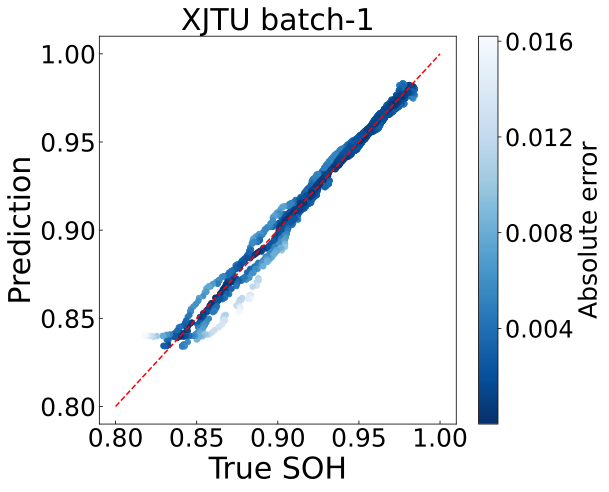

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
# 示例数据
true_soh=np.concatenate((test_results[0][0],test_results[1][0],test_results[2][0]),axis=0)/2
# true_soh = test_results[1][0]
prediction=np.concatenate((test_results[0][1].reshape(-1),test_results[1][1].reshape(-1),test_results[2][1].reshape(-1)),axis=0)/2
# prediction = test_results[1][1].reshape(-1)

print(true_soh)
print(prediction)
def filter_arrays(arr1, arr2, threshold=0.8):
    """
    删除第一个数组中小于阈值的部分，并根据第一个数组删除的索引，删除第二个数组的对应值。

    参数:
    arr1 (np.array): 第一个数组。
    arr2 (np.array): 第二个数组。
    threshold (float): 阈值，默认为0.8。

    返回:
    filtered_arr1 (np.array): 过滤后的第一个数组。
    filtered_arr2 (np.array): 过滤后的第二个数组。
    """
    # 检查两个数组长度是否相同
    if len(arr1) != len(arr2):
        raise ValueError("两个数组的长度必须相同！")

    # 找到第一个数组中大于等于阈值的索引
    valid_indices = arr1 >= threshold

    # 根据索引过滤两个数组
    filtered_arr1 = arr1[valid_indices]
    filtered_arr2 = arr2[valid_indices]

    return filtered_arr1, filtered_arr2
true_soh,prediction=filter_arrays(true_soh,prediction)
# print(true_soh)
# print(prediction.reshape(-1))
distance = np.abs(true_soh - prediction) / np.sqrt(2)
# print(distance)
# 创建散点图
plt.figure(figsize=(8, 7))
scatter = plt.scatter(true_soh, prediction, c=distance, cmap='Blues_r', alpha=1,s=30)

# 添加中间红线
plt.plot([0.80, 1.00], [0.80, 1.00], color='red', linestyle='--')
plt.xticks(np.arange(0.80, 1.01, 0.05),fontsize=25)
plt.yticks(np.arange(0.80, 1.01, 0.05),fontsize=25)
# 添加颜色条
cbar = plt.colorbar(scatter)
cbar.set_label('Absolute error',fontsize=25)
cbar.ax.tick_params(labelsize=24)
# 设置最大刻度数为5
cbar.locator = MaxNLocator(nbins=5)
# 实际显示刻度数 = nbins + 1
cbar.update_ticks()
# 将刻度线画在坐标轴内部
plt.tick_params(axis='both', direction='in')

# 添加标签和标题
plt.xlabel('True SOH',fontsize=30)
plt.ylabel('Prediction',fontsize=30)
plt.title('XJTU batch-1',fontsize=30)
# plt.legend()

# 显示图表
plt.show()

# MLP

In [11]:
class MLP(nn.Module):
    def __init__(self, input_size=11, output_size=1):
        super(MLP, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_size, 32),
                                 nn.ReLU(),
                                 nn.Linear(32, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, 128),
                                 nn.ReLU(),
                                 nn.Linear(128, 256),
                                 nn.ReLU(),
                                 nn.Linear(256, 128),
                                 nn.ReLU(),
                                 nn.Linear(128, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, output_size))
    def forward(self, x):
        return self.net(x)
def train_mlp(lr=0.001,epochs=150, weight_decay=1e-4, seed=0, metric='rmse', device='cpu'):
    """function for train"""
    setup_seed(seed)
    print("training seed "+str(seed)+':\n')
    train_loader, val_loader, test_35_data, test_36_data, test_37_data=get_data()
    test_data=[test_35_data, test_36_data, test_37_data]
    model = MLP()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    len_dataloader = len(train_loader)
    test_results=[]
    """早停止获取最佳模型"""
    val_mse=10
    for epoch in range(epochs):
        loss_epoch=0
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            y_pred= model(X)
            y_pred = y_pred.squeeze(1)
            loss = criterion(y_pred,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss
        if (epoch+1)%5==0 and epoch!=0:
            print('Epoch:',epoch+1,'Train_RMSELoss:',loss_epoch/len_dataloader,'\n')
        if (epoch+1)%5==0 and epoch!=0:
            val_loss=0
            for val_x,val_y in val_loader:
                val_x,val_y=val_x.to(device),val_y.to(device)
                pre=model(val_x)
                val_loss+=criterion(pre.squeeze(1),val_y).detach()    
            print('Epoch:',epoch+1,'valid_RMSELoss:',val_loss/len(val_loader),'\n')
            val_mse=val_loss/len(val_loader)
                
        if (val_mse<10e-6 and epoch>=35)or (epoch+1)==epochs:
            model=model.cpu()
            for name in test_data:
                X=torch.from_numpy(name[0]).float()
                y=name[1]
                y_pred=model(X)
                y_pred= y_pred.squeeze(0).detach().numpy()
                test_results.append([y,y_pred])
            break
    return test_results
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [12]:
tests_mlp=[]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for i in range(5):
    test_result=train_mlp(seed=i,device=device)
    tests_mlp.append(test_result)

training seed 0:

Epoch: 5 Train_RMSELoss: tensor(0.5914, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(0.4383, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(0.0526, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(0.0181, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(0.0050, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(0.0105, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(0.0068, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(0.0069, device='cuda:0') 

Epoch: 30 Train_RMSELoss: tensor(0.0073, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 30 valid_RMSELoss: tensor(0.0068, device='cuda:0') 

Epoch: 35 Train_RMSELoss: tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 35 valid_RMSELoss: tensor(0.0

In [13]:
rmse_all=[]
mae_all=[]
mape_all=[]
r2=[]
num=0
test_csv_m=[]
real_csv_m=[]
for i in range(4):
    for j in range(len(tests[0])):
        real,pred=tests_mlp[i][j][0],tests_mlp[i][j][1].reshape(-1)
        rmse=evaluation(real,pred)
        if rmse>=0.00:
            rmse_all.append(rmse)
            for pre,rea in zip(pred,real):
                test_csv_m.append(pre)
                real_csv_m.append(rea)
        mae_all.append(calculate_mae(real,pred))
        mape_all.append(mape(real,pred))
        r2.append(r_squared(real,pred))
        num+=1
print("RMSE:",rmse_all)
print("test:",test_csv_m)
print('real:',real_csv_m)
len(test_csv_m)

RMSE: [0.06579309963625525, 0.04369057865227705, 0.07827775554412972, 0.054498844378237786, 0.03015673380193217, 0.05696909486989024, 0.047771423017905545, 0.07634437184544592, 0.05322217859457591, 0.06438953793415107, 0.04106047272341061, 0.08376067756217095]
test: [1.9783419, 1.9930364, 2.0076125, 2.013209, 2.0052583, 1.9952407, 1.9891001, 1.982112, 1.9801968, 1.9879245, 2.0004406, 2.0050478, 2.0089183, 2.005451, 2.0007381, 1.9964179, 1.9936289, 1.9937927, 1.9965345, 1.9923931, 1.9893587, 1.987604, 1.9836841, 1.9811462, 1.9767555, 1.9721684, 1.9697926, 1.9712226, 1.9717046, 1.9690915, 1.9659452, 1.96814, 1.9700738, 1.9677821, 1.9726198, 1.9732922, 1.9721942, 1.9742447, 1.9734122, 1.973393, 1.9737891, 1.9748913, 1.9753982, 1.9763905, 1.9782592, 1.9786667, 1.98041, 1.9814152, 1.9818599, 1.9822819, 1.9828662, 1.9805647, 1.9814078, 1.9833852, 1.9854901, 1.9847124, 1.9855019, 1.9844364, 1.9846395, 1.9850485, 1.987139, 1.9845613, 1.9839524, 1.9818798, 1.9809242, 1.979842, 1.9798709, 1.9805

6480

In [37]:
# rmse_all=0
# mae_all=0
# num=0
# for i in range(len(tests_mlp)):
#     for j in range(len(tests_mlp[0])):
#         real,pred=tests_mlp[i][j][0],tests_mlp[i][j][1]
#         rmse=evaluation(real,pred)
#         rmse_all+=(rmse)
#         mae_all+=calculate_mae(real,pred)
#         num+=1
# print('RMSE:',[rmse_all/num])
# print('MAE:',mae_all/num)

RMSE: [0.047205495197372674]
MAE: [0.03864157]


In [14]:
class ConvNet(nn.Module):
    def __init__(self, n_input=11):
        super(ConvNet, self).__init__()
        # 输入重塑为 (batch, 1, n_input)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * (n_input // 2), 64)  # 根据池化后的维度调整
        self.fc2 = nn.Sequential(nn.Linear(64 , 256),
                                 nn.ReLU(),
                                 nn.Linear(256, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, 32),
                                 nn.ReLU(),
                                 nn.Linear(32, 1),)
    
    def forward(self, x):
        # 输入 x 的形状: (batch, n_input)
        x = x.unsqueeze(1)  # 重塑为 (batch, 1, n_input)
        x = self.conv1(x)   # 卷积后形状: (batch, 32, n_input)
        x = self.relu(x)
        x = self.pool(x)    # 池化后形状: (batch, 32, n_input // 2)
        x = x.view(x.size(0), -1)  # 展平为 (batch, 32 * (n_input // 2))
        x = self.fc1(x)     # 全连接层
        x = self.relu(x)
        x = self.fc2(x)     # 输出形状: (batch, 1)
        return x
def train_conv(lr=0.001,epochs=150, weight_decay=1e-4, seed=0, metric='rmse', device='cpu'):
    """function for train"""
    setup_seed(seed)
    print("training seed "+str(seed)+':\n')
    train_loader, val_loader, test_35_data, test_36_data, test_37_data=get_data()
    test_data=[test_35_data, test_36_data, test_37_data]
    model = ConvNet()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    len_dataloader = len(train_loader)
    test_results=[]
    """早停止获取最佳模型"""
    val_mse=10
    for epoch in range(epochs):
        loss_epoch=0
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            y_pred= model(X)
            y_pred = y_pred.squeeze(1)
            loss = criterion(y_pred,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss
        if (epoch+1)%5==0 and epoch!=0:
            print('Epoch:',epoch+1,'Train_RMSELoss:',loss_epoch/len_dataloader,'\n')
        if (epoch+1)%5==0 and epoch!=0:
            val_loss=0
            for val_x,val_y in val_loader:
                val_x,val_y=val_x.to(device),val_y.to(device)
                pre=model(val_x)
                val_loss+=criterion(pre.squeeze(1),val_y).detach()    
            print('Epoch:',epoch+1,'valid_RMSELoss:',val_loss/len(val_loader),'\n')
            val_mse=val_loss/len(val_loader)
                
        if (val_mse<5e-5 and epoch>=10)or (epoch+1)==epochs:
            model=model.cpu()
            for name in test_data:
                X=torch.from_numpy(name[0]).float()
                y=name[1]
                y_pred=model(X)
                y_pred= y_pred.squeeze(0).detach().numpy()
                test_results.append([y,y_pred])
            break
    return test_results
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [15]:
tests_cnn=[]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for i in range(5):
    test_result=train_conv(seed=i,device=device)
    tests_cnn.append(test_result)

training seed 0:

Epoch: 5 Train_RMSELoss: tensor(0.3934, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(0.2041, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(0.0246, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(0.0249, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(0.0250, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(0.0123, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(0.0079, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(0.0088, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(0.0266, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(0.0340, device='cuda:0') 

Epoch: 30 Train_RMSELoss: tensor(0.0064, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 30 valid_RMSELoss: tensor(0.0068, device='cuda:0') 

Epoch: 35 Train_RMSELoss: tensor(0.0077, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 35 valid_RMSELoss: tensor(0.0

In [16]:
rmse_all=[]
mae_all=[]
mape_all=[]
r2=[]
num=0
test_csv_c=[]
real_csv_c=[]
for i in range(4):
    for j in range(len(tests[0])):
        real,pred=tests_cnn[i][j][0],tests_cnn[i][j][1].reshape(-1)
        rmse=evaluation(real,pred)
        if rmse>=0.00:
            rmse_all.append(rmse)
            for pre,rea in zip(pred,real):
                test_csv_c.append(pre)
                real_csv_c.append(rea)
        mae_all.append(calculate_mae(real,pred))
        mape_all.append(mape(real,pred))
        r2.append(r_squared(real,pred))
        num+=1
print("RMSE:",rmse_all)
print("test:",test_csv_c)
print('real:',real_csv_c)
len(test_csv_c)

RMSE: [0.026876875666067716, 0.03667581140951337, 0.03262136518974459, 0.0256826560034684, 0.03793627614116888, 0.04461663008145203, 0.020440473757718788, 0.027164748638271043, 0.02745706394945903, 0.07214482056667017, 0.0934308085398261, 0.06110497562697104]
test: [1.9305291, 1.9391352, 1.9417211, 1.9414262, 1.9416263, 1.9414591, 1.9412313, 1.9410135, 1.9424206, 1.946821, 1.9562334, 1.9565414, 1.9577148, 1.9609038, 1.9579908, 1.9543207, 1.9513149, 1.9520112, 1.9536532, 1.9462477, 1.9397581, 1.9383911, 1.9346457, 1.9323089, 1.9207755, 1.9173706, 1.9143149, 1.9161091, 1.916301, 1.9145496, 1.9106654, 1.9110394, 1.9119263, 1.9076035, 1.9127916, 1.9128464, 1.9114112, 1.9136225, 1.9125451, 1.9133303, 1.9153024, 1.9183891, 1.9200779, 1.9202868, 1.923734, 1.9244787, 1.9239228, 1.9261378, 1.9261335, 1.9281925, 1.9282331, 1.9264562, 1.9277047, 1.93342, 1.9342442, 1.9324211, 1.9329022, 1.9304911, 1.9290968, 1.9276642, 1.9300681, 1.9281818, 1.926776, 1.9360262, 1.9321516, 1.9301649, 1.9290824, 1.

6480

In [17]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size=11, hidden_size=60, num_layers=6, output_size=1):
        """
        LSTM网络初始化
        :param input_size: 输入特征的维度 (n)
        :param hidden_size: 隐藏层的维度
        :param num_layers: LSTM的层数
        :param output_size: 输出的维度 (1)
        """
        super(LSTMNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 定义LSTM层
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # 定义全连接层，将LSTM的输出映射到输出维度
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        前向传播
        :param x: 输入数据，形状为 (batch_size, input_size)
        :return: 输出数据，形状为 (batch_size, output_size)
        """
        # 添加序列维度 (sequence_length=1)
        x = x.unsqueeze(1)  # 形状变为 (batch_size, 1, input_size)

        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM前向传播
        out, _ = self.lstm(x, (h0, c0))  # out的形状为 (batch_size, 1, hidden_size)

        # 只取最后一个时间步的输出
        out = out[:, -1, :]  # 形状为 (batch_size, hidden_size)

        # 全连接层映射到输出维度
        out = self.fc(out)  # 形状为 (batch_size, output_size)

        return out

def train_lstm(lr=0.001,epochs=150, weight_decay=1e-4, seed=0, metric='rmse', device='cpu'):
    """function for train"""
    setup_seed(seed)
    print("training seed "+str(seed)+':\n')
    train_loader, val_loader, test_35_data, test_36_data, test_37_data=get_data()
    test_data=[test_35_data, test_36_data, test_37_data]
    model = LSTMNetwork()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    len_dataloader = len(train_loader)
    test_results=[]
    """早停止获取最佳模型"""
    val_mse=10
    for epoch in range(epochs):
        loss_epoch=0
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            y_pred= model(X)
            y_pred = y_pred.squeeze(1)
            loss = criterion(y_pred,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss
        if (epoch+1)%5==0 and epoch!=0:
            print('Epoch:',epoch+1,'Train_RMSELoss:',loss_epoch/len_dataloader,'\n')
        if (epoch+1)%5==0 and epoch!=0:
            val_loss=0
            for val_x,val_y in val_loader:
                val_x,val_y=val_x.to(device),val_y.to(device)
                pre=model(val_x)
                val_loss+=criterion(pre.squeeze(1),val_y).detach()    
            print('Epoch:',epoch+1,'valid_RMSELoss:',val_loss/len(val_loader),'\n')
            val_mse=val_loss/len(val_loader)
                
        if (val_mse<5e-5 and epoch>=10)or (epoch+1)==epochs:
            model=model.cpu()
            for name in test_data:
                X=torch.from_numpy(name[0]).float()
                y=name[1]
                y_pred=model(X)
                y_pred= y_pred.squeeze(0).detach().numpy()
                test_results.append([y,y_pred])
            break
    return test_results
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [18]:
tests_lstm=[]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for i in range(5):
    test_result=train_lstm(seed=i,device=device)
    tests_lstm.append(test_result)

training seed 0:

Epoch: 5 Train_RMSELoss: tensor(0.5487, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(0.0446, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(0.0108, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(0.0090, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(0.0047, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(0.0048, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(0.0026, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(0.0017, device='cuda:0') 

Epoch: 30 Train_RMSELoss: tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 30 valid_RMSELoss: tensor(0.0013, device='cuda:0') 

Epoch: 35 Train_RMSELoss: tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 35 valid_RMSELoss: tensor(0.0

In [19]:
rmse_all=[]
mae_all=[]
mape_all=[]
r2=[]
num=0
test_csv_l=[]
real_csv_l=[]
for i in range(4):
    for j in range(len(tests_lstm[0])):
        real,pred=tests_lstm[i][j][0],tests_lstm[i][j][1].reshape(-1)
        rmse=evaluation(real,pred)
        if rmse>=0.0:
            rmse_all.append(rmse)
            for pre,rea in zip(pred,real):
                test_csv_l.append(pre)
                real_csv_l.append(rea)
        mae_all.append(calculate_mae(real,pred))
        mape_all.append(mape(real,pred))
        r2.append(r_squared(real,pred))
        num+=1
print("RMSE:",rmse_all)
print("test:",test_csv_l)
print('real:',real_csv_l)
len(test_csv_l)

RMSE: [0.020863119961708153, 0.023464395405537446, 0.022466599726453425, 0.02449262617976955, 0.02644633221682224, 0.023341887835378557, 0.01599801482030712, 0.018159587403834453, 0.017010776116373263, 0.021793015922070516, 0.024665438819162278, 0.023181150519492464]
test: [1.7888083, 1.8271024, 1.8562379, 1.8785905, 1.895926, 1.9095265, 1.9203182, 1.9289727, 1.9362901, 1.9423839, 1.9477098, 1.9515997, 1.9549521, 1.9578438, 1.9599328, 1.961719, 1.9631606, 1.9646808, 1.9661242, 1.9667281, 1.9676559, 1.9684329, 1.9688872, 1.9691597, 1.9693255, 1.9694136, 1.9694494, 1.9696933, 1.9697137, 1.9696279, 1.9692261, 1.9693453, 1.9693124, 1.9689419, 1.9690924, 1.9689779, 1.9687201, 1.9686627, 1.9682217, 1.9678943, 1.9676476, 1.9674096, 1.9672155, 1.9670645, 1.9668982, 1.966481, 1.96611, 1.9657853, 1.9653519, 1.9648833, 1.9646082, 1.9640882, 1.9636481, 1.9631441, 1.9629027, 1.9623389, 1.9620585, 1.9615033, 1.9610231, 1.9605896, 1.9602125, 1.9594467, 1.9588735, 1.9586165, 1.9578788, 1.9573395, 1.95

6480

In [20]:
import pandas as pd
data={
    'prop pred':test_csv_p,
    'prop real':real_csv_p,
    'mlp pred': test_csv_m,
    'mlp real':real_csv_m,
    'cnn pred': test_csv_c,
    'cnn real':real_csv_c,
    'lstm pred':test_csv_l,
    'lstm real':real_csv_l,
}
df=pd.DataFrame(data)
print(df)
df.to_csv('../csv_results/xjtu.csv',index=False)

      prop pred  prop real  mlp pred  mlp real  cnn pred  cnn real  lstm pred  \
0      1.952691      1.963  1.978342     1.963  1.930529     1.963   1.788808   
1      1.953426      1.962  1.993036     1.962  1.939135     1.962   1.827102   
2      1.954059      1.962  2.007612     1.962  1.941721     1.962   1.856238   
3      1.954617      1.961  2.013209     1.961  1.941426     1.961   1.878590   
4      1.955176      1.960  2.005258     1.960  1.941626     1.960   1.895926   
...         ...        ...       ...       ...       ...       ...        ...   
6475   1.674112      1.647  1.892118     1.647  1.647983     1.647   1.697512   
6476   1.673858      1.644  1.897010     1.644  1.647284     1.644   1.697008   
6477   1.673604      1.640  1.901566     1.640  1.649709     1.640   1.696495   
6478   1.673352      1.637  1.905347     1.637  1.652977     1.637   1.695826   
6479   1.673102      1.636  1.913125     1.636  1.651022     1.636   1.695920   

      lstm real  
0        

In [40]:
rmse_all=0
mae_all=0
num=0
for i in range(len(tests_cnn)):
    for j in range(len(tests_cnn[0])):
        real,pred=tests_cnn[i][j][0],tests_cnn[i][j][1]
        rmse=evaluation(real,pred)
        rmse_all+=(rmse)
        mae_all+=calculate_mae(real,pred)
        num+=1
print('RMSE:',[rmse_all/num])
print('MAE:',mae_all/num)

RMSE: [0.04988660577758232]
MAE: [0.03999891]
